# Cross-link 2407-dataset

The dataset has the cross-link maps per detector in $N_{\rm side}=128$ in HDF5 format.
The configration of the simulation as follows:

- Software: Falcons.jl v1.0.1
- IMo version: IMo-v2
- Sampling rate: 19 Hz
- Considered spin number $n$: 1 to 5
- No HWP
- Directory structure:
  - Channel names (22 bands)
    - Detector names (Only `Top`-detector, total number of files: 4508/2)
    - Naming rule: `nside128_{detname}.h5`
  - Boresight


In [1]:
import h5py
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import os
import copy

class Scanfield:
    def __init__(self, file_path):
        with h5py.File(file_path, 'r') as f:
            self.ss = {key: value[()] for key, value in zip(f['ss'].keys(), f['ss'].values()) if key != "quat"}
            self.hitmap = f['hitmap'][:]
            self.h = f['h'][:, 0, :]
            self.h[np.isnan(self.h)] = 1.0
            quantify_group = f['quantify']
            self.spins = quantify_group['n'][()]
            self.mean = quantify_group['mean'][()]
            self.std = quantify_group['std'][()]

    def get_xlink(self, spin_n):
        assert spin_n > 0, "spin_n must be greater than 0"
        return self.h[:, spin_n - 1]

    def t2b(self):
        """Transform Top detector cross-link to Bottom detector cross-link
        Top and bottom detector make a orthogonal pair.
        """
        class_copy = copy.deepcopy(self)
        class_copy.h *= np.exp(-1j * self.spins * (np.pi / 2))
        return class_copy

    def __add__(self, other):
        """Add hitmap and h of two Scanfield instances"""
        if not isinstance(other, Scanfield):
            return NotImplemented
        result = copy.deepcopy(self)
        result.hitmap += other.hitmap
        result.h = (self.h*self.hitmap[:, np.newaxis] + other.h*other.hitmap[:, np.newaxis])/result.hitmap[:, np.newaxis]
        result.mean = np.array([np.mean(result.hitmap), np.mean(result.h, axis=0)[0]])
        result.std = np.array([np.std(result.hitmap), np.std(result.h, axis=0)[0]])
        return result

class Scanfield_channel:
    def __init__(self, base_path, channel):
        dirpath = os.path.join(base_path, channel)
        filenames = os.listdir(dirpath)
        first_sf = Scanfield(os.path.join(dirpath, filenames[0]))
        self.hitmap = np.zeros_like(first_sf.hitmap)
        self.h = np.zeros_like(first_sf.h)
        for name in filenames:
            sf = Scanfield(os.path.join(dirpath, name))
            self.hitmap += sf.hitmap
            self.h += sf.hitmap[:, np.newaxis] * sf.h
        self.h /= self.hitmap[:, np.newaxis]
        self.mean = np.array([np.mean(self.hitmap), np.mean(self.h, axis=0)[0]])
        self.std = np.array([np.std(self.hitmap), np.std(self.h, axis=0)[0]])
        self.spins = first_sf.spins

    def get_xlink(self, spin_n):
        assert spin_n > 0, "spin_n must be greater than 0"
        return self.h[:, spin_n - 1]

    def t2b(self):
        """Transform Top detector cross-link to Bottom detector cross-link
        Top and bottom detector make a orthogonal pair.
        """
        class_copy = copy.deepcopy(self)
        class_copy.h *= np.exp(-1j * self.spins * (np.pi / 2))
        return class_copy

    def __add__(self, other):
        """Add hitmap and h of two Scanfield instances"""
        if not isinstance(other, Scanfield_channel):
            return NotImplemented
        result = copy.deepcopy(self)
        result.hitmap += other.hitmap
        result.h = (self.h*self.hitmap[:, np.newaxis] + other.h*other.hitmap[:, np.newaxis])/result.hitmap[:, np.newaxis]
        result.mean = np.array([np.mean(result.hitmap), np.mean(result.h, axis=0)[0]])
        result.std = np.array([np.std(result.hitmap), np.std(result.h, axis=0)[0]])
        return result

class Scanfield_total:
    def __init__(self, base_path, channel_list):
        self.base_path = base_path
        self.channel_list = channel_list
        self.crosslink_channels = []
        for ch in channel_list:
            print("...loading channel: ", ch)
            self.crosslink_channels.append(Scanfield_channel(base_path, ch))
        self.hitmap = np.zeros_like(self.crosslink_channels[0].hitmap)
        self.h = np.zeros_like(self.crosslink_channels[0].h)
        for sf in self.crosslink_channels:
            self.hitmap += sf.hitmap
            self.h += sf.hitmap[:, np.newaxis] * sf.h
        self.h /= self.hitmap[:, np.newaxis]
        self.mean = np.array([np.mean(self.hitmap), np.mean(self.h, axis=0)[0]])
        self.std = np.array([np.std(self.hitmap), np.std(self.h, axis=0)[0]])
        self.spins = self.crosslink_channels[0].spins

    def get_xlink(self, spin_n):
        assert spin_n > 0, "spin_n must be greater than 0"
        return self.h[:, spin_n - 1]

    def t2b(self):
        """Transform Top detector cross-link to Bottom detector cross-link
        Top and bottom detector make a orthogonal pair.
        """
        class_copy = copy.deepcopy(self)
        class_copy.h *= np.exp(-1j * self.spins * (np.pi / 2))
        return class_copy

    def __add__(self, other):
        """Add hitmap and h of two Scanfield instances"""
        if not isinstance(other, Scanfield_total):
            return NotImplemented
        result = copy.deepcopy(self)
        result.hitmap += other.hitmap
        result.h = (self.h*self.hitmap[:, np.newaxis] + other.h*other.hitmap[:, np.newaxis])/result.hitmap[:, np.newaxis]
        result.mean = np.array([np.mean(result.hitmap), np.mean(result.h, axis=0)[0]])
        result.std = np.array([np.std(result.hitmap), np.std(result.h, axis=0)[0]])
        return result

channel_list = [
    'L1-040',
    'L2-050',
    'L1-060',
    'L3-068',
    'L2-068',
    'L4-078',
    'L1-078',
    'L3-089',
    'L2-089',
    'L4-100',
    'L3-119',
    'L4-140',
    'M1-100',
    'M2-119',
    'M1-140',
    'M2-166',
    'M1-195',
    'H1-195',
    'H2-235',
    'H1-280',
    'H2-337',
    'H3-402'
]

# Definision of cross-link

We define the cross-link as:
$$ 
{}_{n}\tilde{h} = \frac{1}{N_{\rm hits}}\sum_{j}e^{-in\psi_j}
= \langle \cos(n\psi_j) \rangle + i\langle \sin(n\psi_j) \rangle
$$
where $\psi$ represents crossing angle, and $j$ represents $j^{\rm{th}}$ measurement in a sky pixel. $N_{\rm hits}$ represents number of hits in a sky pixel.

You can get the value of it by `get_xlink(data, spin_n)` with specified spin number. In the 2407-dataset, you can access spin 1 to 5.


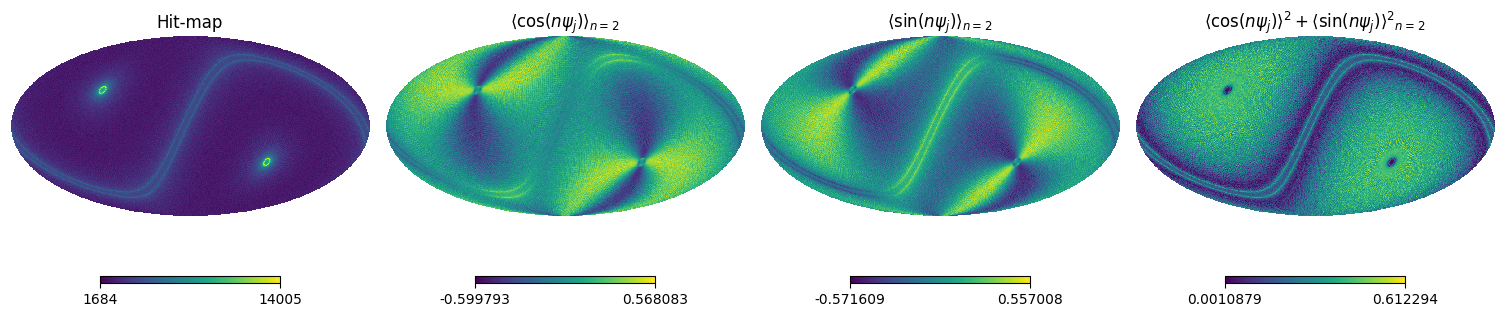

In [21]:
# Load single detector map
base_path = "../crosslinks_2407"
#sf1 = Scanfield(base_path+"/boresight/nside128_boresight.h5")
sf1 = Scanfield(base_path+"/L1-040/nside128_000_000_003_QA_040_T.h5")
sf2 = Scanfield(base_path+"/L1-040/nside128_000_004_005_UA_040_T.h5")

spin_n = 2
C = r"$\langle \cos(n\psi_j)\rangle$"
S = r"$\langle \sin(n\psi_j)\rangle$"

plt.figure(figsize=(15,12))
hp.mollview(sf1.hitmap, title="Hit-map", sub=(1,4,1))
hp.mollview(sf1.get_xlink(spin_n).real, title=C + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,2))
hp.mollview(sf1.get_xlink(spin_n).imag, title=S + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,3))
hp.mollview(np.abs(sf1.get_xlink(spin_n)), title=C+"$^2 + $" + S + "$^2$" + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,4))

# Scan-field operation
If you add two `Scanfield` instances, the hit-map and ${}_{n}\tilde{h}$ will be added by the special method: `__add__()`.

The hit-map is added by simple addition, and ${}_{n}\tilde{h}$ is added by weighted average:
$$ 
N_{\rm hits}^{\rm tot} = N_{\rm hits}^{(1)} + N_{\rm hits}^{(2)} \\
$$
$$
{}_{n}\tilde{h}^{\rm tot} = \frac{{}_{n}\tilde{h}^{(1)} N_{\rm hits}^{(1)} + {}_{n}\tilde{h}^{(2)} N_{\rm hits}^{(2)}}{N_{\rm hits}^{\rm tot}}
$$
where the number in $(.)$ represents a detector ID. 

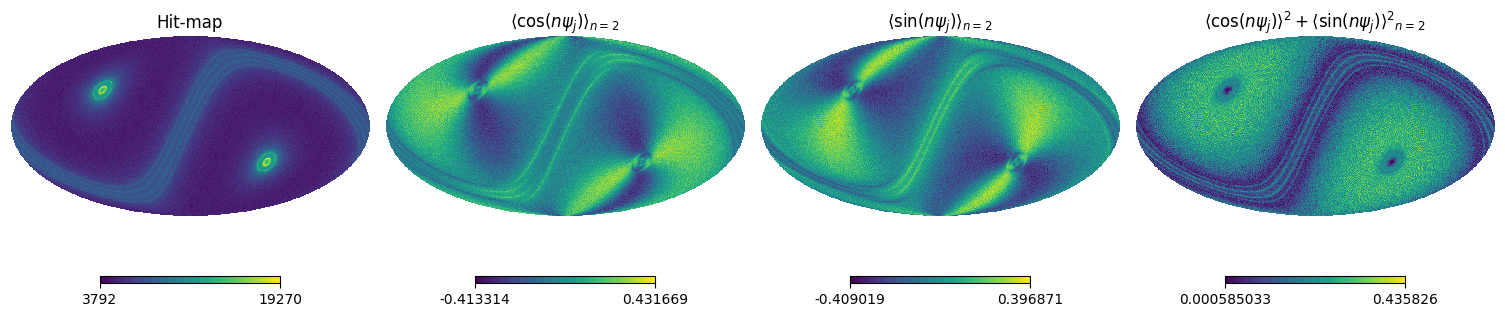

In [4]:
# add Scanfield instances
sf_sum = sf1 + sf2
spin_n = 2

plt.figure(figsize=(15,12))
hp.mollview(sf_sum.hitmap, title="Hit-map", sub=(1,4,1))
hp.mollview(sf_sum.get_xlink(spin_n).real, title=C + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,2))
hp.mollview(sf_sum.get_xlink(spin_n).imag, title=S + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,3))
hp.mollview(np.abs(sf_sum.get_xlink(spin_n)), title=C+"$^2 + $" + S + "$^2$" + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,4))

In [5]:
# Load maps per channel
base_path = "../crosslinks_2407"
channel = "L1-040"
sf_ch = Scanfield_channel(base_path, channel)

In [6]:
# Load total map (It takes a while ~2-5 minutes)
sf_total = Scanfield_total(base_path, channel_list)

...loading channel:  L1-040
...loading channel:  L2-050
...loading channel:  L1-060
...loading channel:  L3-068
...loading channel:  L2-068
...loading channel:  L4-078
...loading channel:  L1-078
...loading channel:  L3-089
...loading channel:  L2-089
...loading channel:  L4-100
...loading channel:  L3-119
...loading channel:  L4-140
...loading channel:  M1-100
...loading channel:  M2-119
...loading channel:  M1-140
...loading channel:  M2-166
...loading channel:  M1-195
...loading channel:  H1-195
...loading channel:  H2-235
...loading channel:  H1-280
...loading channel:  H2-337
...loading channel:  H3-402


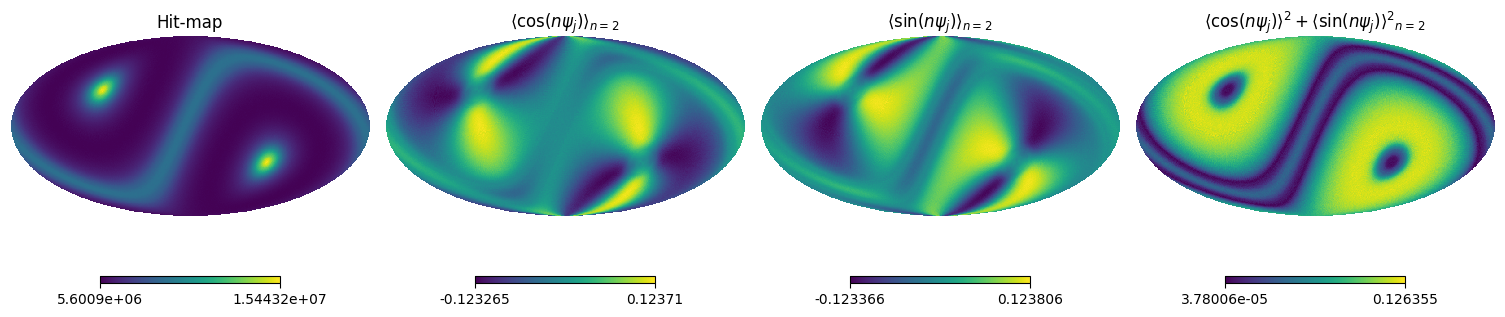

In [7]:
spin_n = 2
plt.figure(figsize=(15,12))
hp.mollview(sf_total.hitmap, title="Hit-map", sub=(1,4,1))
hp.mollview(sf_total.get_xlink(spin_n).real, title=C + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,2))
hp.mollview(sf_total.get_xlink(spin_n).imag, title=S + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,3))
hp.mollview(np.abs(sf_total.get_xlink(spin_n)), title=C+"$^2 + $" + S + "$^2$" + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,4))

## Note that few MHFT detectors cannot observe the ecliptic poles as bellow: 

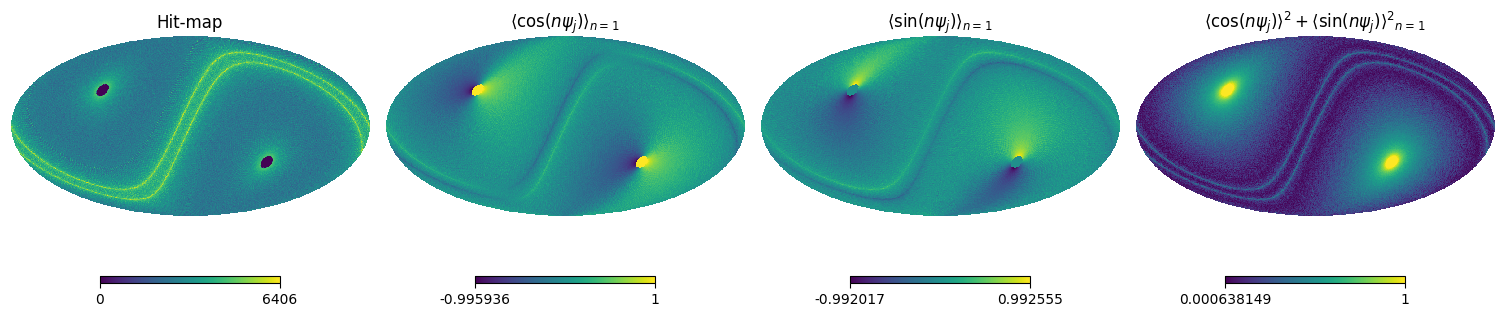

In [8]:
sf = Scanfield("../crosslinks_2407/H1-195/nside128_002_000_000_Q_195_T.h5")
spin_n = 1
plt.figure(figsize=(15,12))
hp.mollview(sf.hitmap, title="Hit-map", sub=(1,4,1))
hp.mollview(sf.get_xlink(spin_n).real, title=C + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,2))
hp.mollview(sf.get_xlink(spin_n).imag, title=S + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,3))
hp.mollview(np.abs(sf.get_xlink(spin_n)), title=C+"$^2 + $" + S + "$^2$" + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,4))

# How to make a full-focal plane data
We generated the total scanfield as:

`sf_total = Scanfield_total(base_path, channel_list)`

However, this data is including only the top-detectors, so we must consider the bottom-detectors as well, which has 90 degrees sifted polarization angle. 

So now, we can use `Scanfield` sumation and top-to-bottom comverter i.e. `.t2b()` method.

Note that `spin-2` corss-link cancels out. 

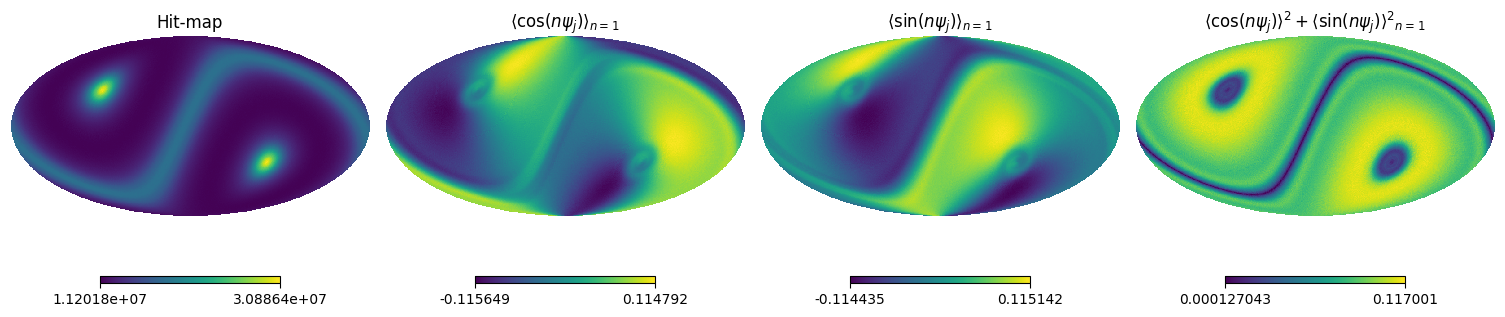

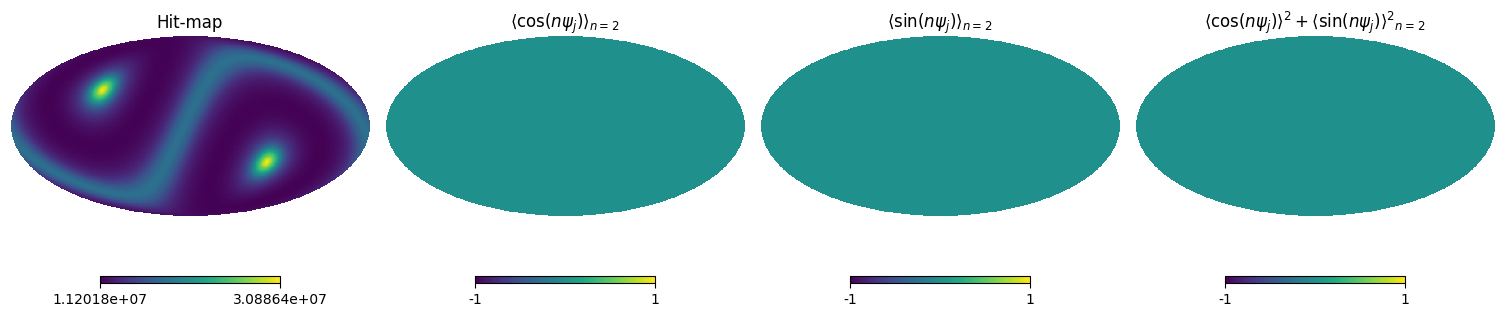

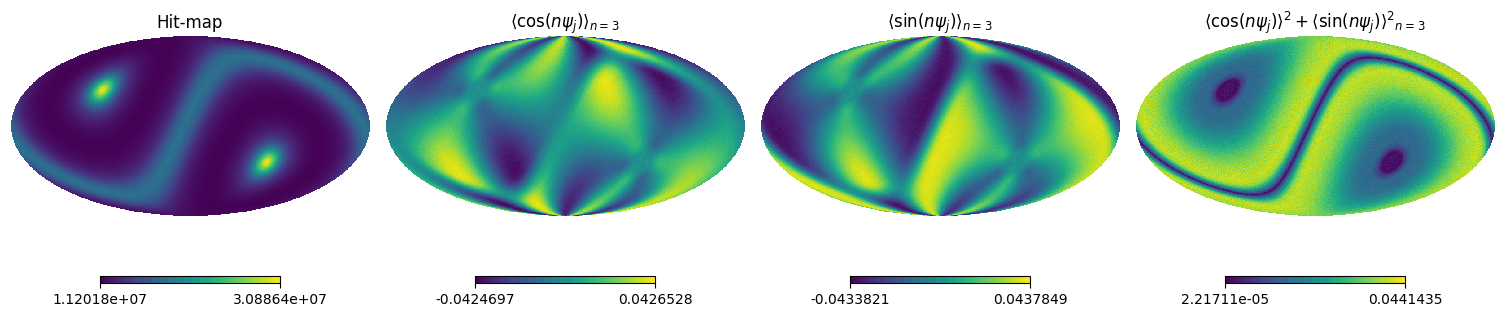

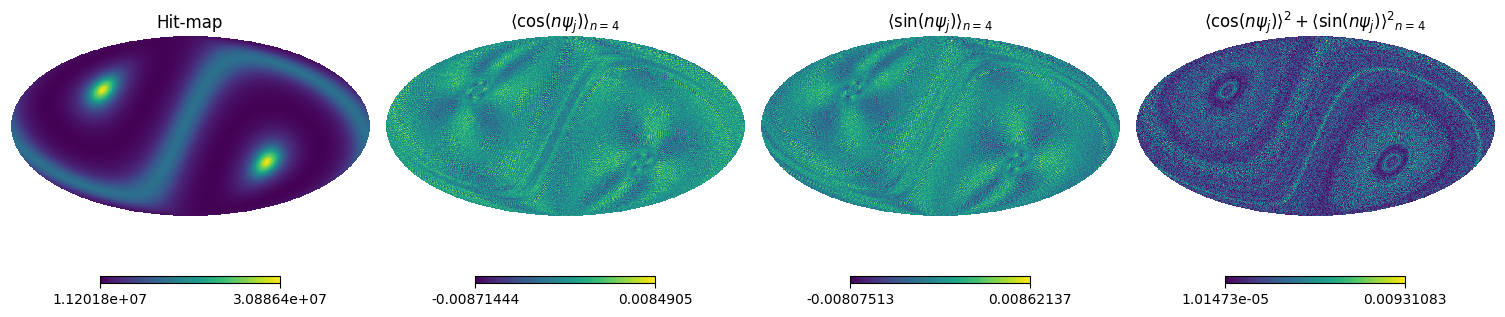

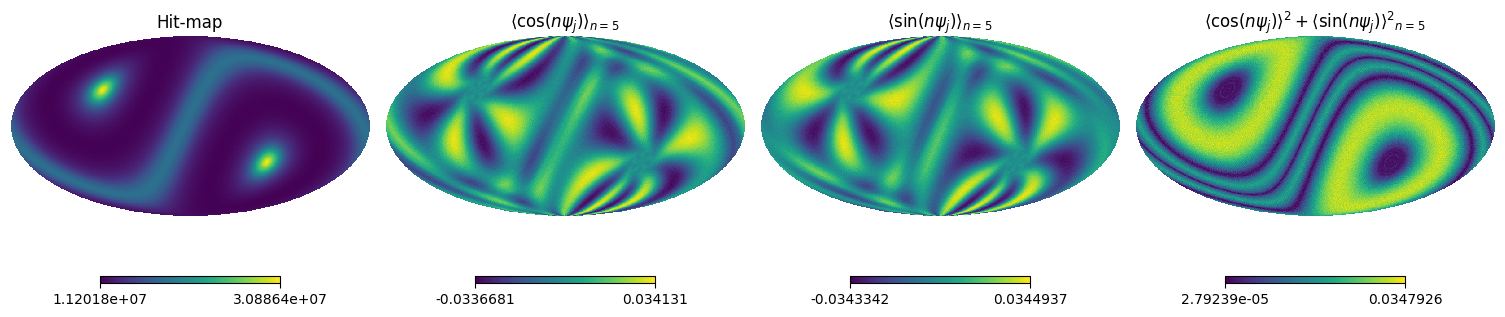

In [22]:
sf_full = sf_total + sf_total.t2b()

for spin_n in range(1,6):
    plt.figure(figsize=(15,12))
    hp.mollview(sf_full.hitmap, title="Hit-map", sub=(1,4,1))
    hp.mollview(sf_full.get_xlink(spin_n).real, title=C + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,2))
    hp.mollview(sf_full.get_xlink(spin_n).imag, title=S + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,3))
    hp.mollview(np.abs(sf_full.get_xlink(spin_n)), title=C+"$^2 + $" + S + "$^2$" + "$_{n=}$" + f"$_{spin_n}$", sub=(1,4,4))